In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import ShuffleSplit
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import uniform, randint
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
import xgboost as xgb
from sklearn.impute import SimpleImputer


# Load and view data

In [2]:
data = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("../input/house-prices-advanced-regression-techniques/test.csv")
data.head(10)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
5,6,50,RL,85.0,14115,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.0,10084,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,307000
7,8,60,RL,NaN,10382,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.0,6120,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.0,7420,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2008,WD,Normal,118000


In [3]:
# Separate features from target 
y = data['SalePrice']
data.drop(columns=['SalePrice'], inplace=True)

In [4]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

# Missing data

<AxesSubplot:>

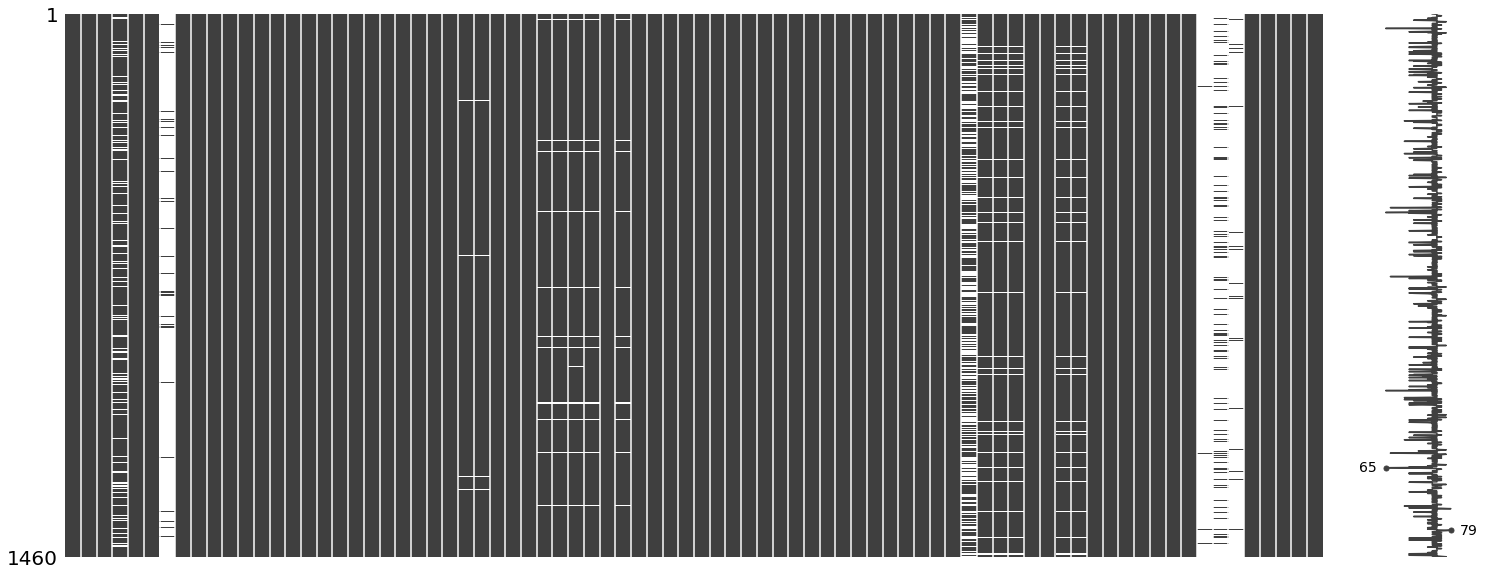

In [6]:
missingno.matrix(data)

In [7]:
missing_values = data.isnull().mean() * 100
missing_values.sort_values(ascending=False).head(10)

PoolQC         99.520548
MiscFeature    96.301370
Alley          93.767123
Fence          80.753425
FireplaceQu    47.260274
LotFrontage    17.739726
GarageType      5.547945
GarageYrBlt     5.547945
GarageQual      5.547945
GarageCond      5.547945
dtype: float64

In [8]:
# Drop 'Id' and features with more than 50% of missing values 
data.drop(columns=['Alley', 'Fence', 'PoolQC', 'MiscFeature', 'FireplaceQu', 'Id'], inplace=True)

# Correlation

<AxesSubplot:>

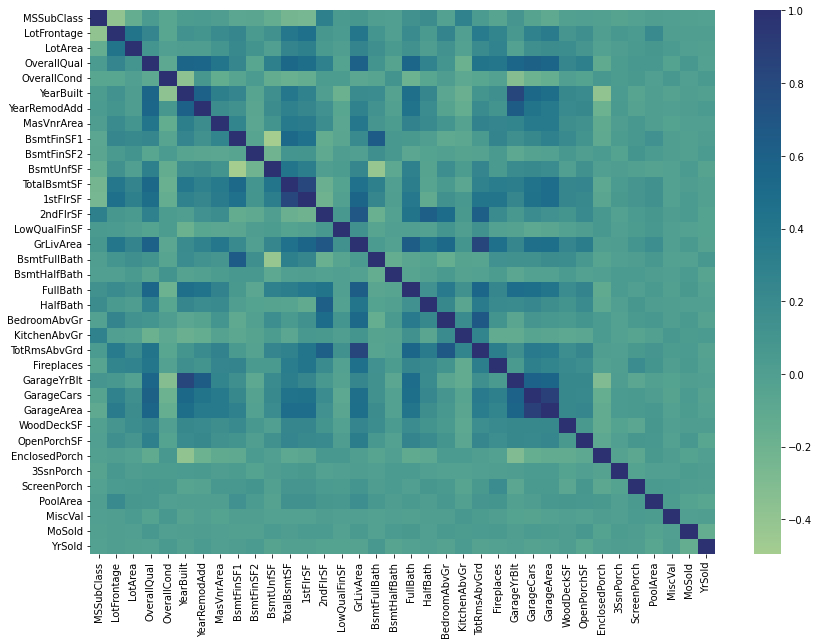

In [9]:
# Heat map
fig = plt.figure(figsize=(14, 10))
sns.heatmap(data.corr(), cmap='crest')

<AxesSubplot:>

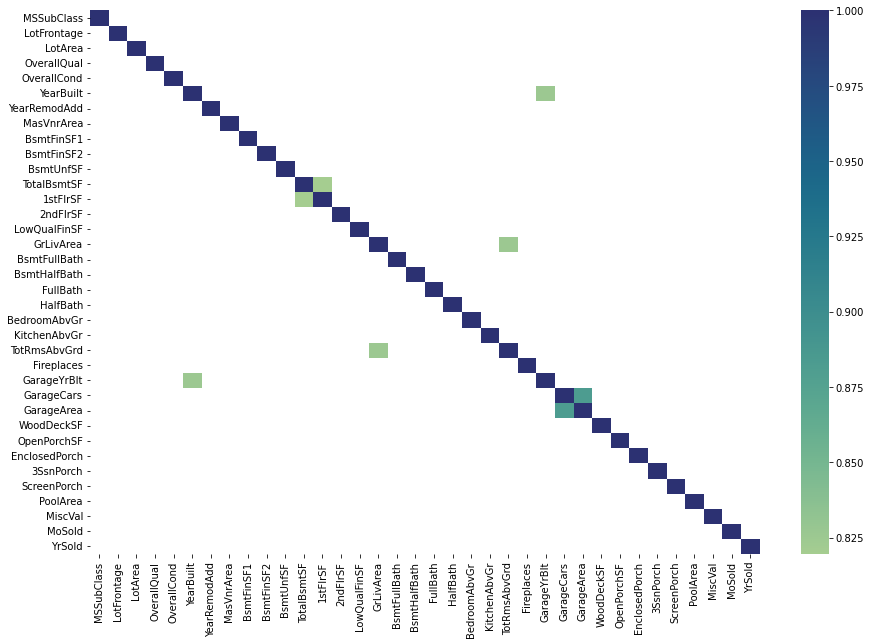

In [10]:
# Show off the features with an absolute correlation more than 0.7
corr = data.corr()
corr_high = corr[np.abs(corr) >= .7]
fig = plt.figure(figsize=(15, 10))
sns.heatmap(corr_high, cmap='crest')

In [11]:
# Drop correlated features
data.drop(columns=['GarageArea', 'GrLivArea', 'GarageYrBlt'], inplace=True)

# Treating Numerical/ Categorical data

In [12]:
def get_features_type(features_type, data):
    return data.select_dtypes(include=features_type)


# Get the numerical features
df_numeric = get_features_type(['int64', 'float64'], data)
# Get the categorical features
df_cat = get_features_type(['object'], data)

In [13]:
# Drop the same features dropped earlier from the trainset
test.drop(columns=['Id', 'Alley', 'Fence', 'PoolQC', 'MiscFeature', 'FireplaceQu'], \
          inplace=True)
test.drop(columns=['GarageArea', 'GrLivArea', 'GarageYrBlt'], inplace=True)
# fill missing data with mean 
test.fillna(test.mean())
# Get the numerical features
df_numeric_test = get_features_type(['int64', 'float64'], test)
# Get the categorical features
df_cat_test = get_features_type(['object'], test)
# concat the train and test sets(the categorical features only)  with preserving the order of the rows
trainTest = df_cat.append(df_cat_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [14]:
# encoding labels:
def encode_labels(data):
    encoded_cat_train_set = data.copy()
    for column in data.columns:
        data[column] = data[column].astype('category')
        encoded_cat_train_set[column] = data[column].cat.codes
    return encoded_cat_train_set


# encode the categorical data
encoded_cat_train_set = encode_labels(trainTest)

# split the trainTest set again
df_cat = encoded_cat_train_set[:1460]
df_cat_test = encoded_cat_train_set[1460:]

In [15]:
# Scale numerical training data
scaler = StandardScaler()
scaled_numeric_train_set = scaler.fit_transform(df_numeric)

df_numric = pd.DataFrame(scaled_numeric_train_set, columns=df_numeric.columns)

In [16]:
numColumns = df_numeric.columns

# fill numeric nans
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
df_numeric = imp.fit_transform(df_numeric)
df_numeric = pd.DataFrame(df_numeric, columns=numColumns)

# fill categoric nan
catColumns = df_cat.columns
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df_cat = imp.fit_transform(df_cat)
df_cat = pd.DataFrame(df_cat, columns=catColumns)

# Merge numercial and catgorical data
train_set = pd.merge(df_numric,
                     df_cat, left_index=True, right_index=True)
X = train_set

# Model 

In [17]:
xgb_model = xgb.XGBRegressor()
params = {
    "colsample_bytree": uniform(0.7, 0.3),
    "importance_type": ['weight', 'gain', 'cover'],
    "gamma": uniform(0, 0.5),
    "learning_rate": uniform(0.03, 0.3),  # default 0.1 
    "max_depth": randint(2, 6),  # default 3
    "n_estimators": randint(100, 150),  # default 100
    "subsample": uniform(0.6, 0.4),
    "num_parallel_tree": randint(1, 5),
    "reg_lambda": randint(0, 5),
    "reg_alpha": randint(0, 5),

}

search = RandomizedSearchCV(xgb_model, \
                            param_distributions=params, \
                            random_state=42, \
                            n_iter=200, \
                            cv=3, \
                            verbose=1, \
                            n_jobs=1, \
                            return_train_score=True)

search.fit(X, y)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, gamma=None,
                                          gpu_id=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          m...
                                        'num_parallel_tree': <scipy.stats._distn_infrastructure.rv_frozen 

# Prediction 

In [18]:
encoded_categoric_test_set = test
scaled_numeric_test_set = scaler.transform(df_numeric_test)
numeric_test_set = pd.DataFrame(scaled_numeric_test_set, \
                                columns=df_numeric.columns)
# Merge numercial and catgorical data
test_set = pd.merge(numeric_test_set,
                    df_cat_test, left_index=True, right_index=True)
test_set.fillna(test_set.mean(), inplace=True)
Xtest = test_set[train_set.columns]

In [19]:
y_predict = search.predict(Xtest)

In [20]:
sample_submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')
output = pd.DataFrame({'Id': sample_submission.Id, 'SalePrice': y_predict})
output.to_csv('submission.csv', index=False)